In [23]:
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [24]:
# def parse_annotation(xml_file, target_size=(224, 224)):
#     tree = ET.parse(xml_file)
#     root = tree.getroot()
#     filename = root.find('filename').text
#     size = root.find('size')
#     width = int(size.find('width').text)
#     height = int(size.find('height').text)
#     for obj in root.iter('object'):
#         xmlbox = obj.find('bndbox')
#         x_min = int(xmlbox.find('xmin').text)
#         y_min = int(xmlbox.find('ymin').text)
#         x_max = int(xmlbox.find('xmax').text)
#         y_max = int(xmlbox.find('ymax').text)
#         # Resize bounding box coordinates
#         x_min_resized = (x_min / width) * target_size[0]
#         y_min_resized = (y_min / height) * target_size[1]
#         x_max_resized = (x_max / width) * target_size[0]
#         y_max_resized = (y_max / height) * target_size[1]
#         return filename, (x_min_resized, y_min_resized, x_max_resized, y_max_resized)

# def load_data(image_directory, annotations_directory, target_size=(224, 224)):
#     images = []
#     boxes = []
#     filenames = []

#     for xml_file in os.listdir(annotations_directory):
#         if xml_file.endswith('.xml'):
#             xml_path = os.path.join(annotations_directory, xml_file)
#             #print(xml_path)
#             filename, bbox_resized = parse_annotation(xml_path)

#             img_path = os.path.join(image_directory, filename)
#             img = cv2.imread(img_path)
#             img = cv2.resize(img, target_size)  # Resize image to ensure consistency

#             images.append(img)
#             boxes.append(bbox_resized)
#             filenames.append(filename)

#     return np.array(images), np.array(boxes), np.array(filenames)

In [25]:
# # Paths to your dataset
# image_directory = 'archive/images'
# annotations_directory = 'archive/annotations'

# images, boxes, filenames = load_data(image_directory, annotations_directory)

In [26]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text
    for obj in root.iter('object'):
        xmlbox = obj.find('bndbox')
        x_min = int(xmlbox.find('xmin').text)
        y_min = int(xmlbox.find('ymin').text)
        x_max = int(xmlbox.find('xmax').text)
        y_max = int(xmlbox.find('ymax').text)
        return filename, (x_min, y_min, x_max, y_max)

def load_data(image_directory, annotations_directory, target_size=(224, 224)):
    images = []
    boxes = []
    filenames = []

    for xml_file in os.listdir(annotations_directory):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(annotations_directory, xml_file)
            filename, bbox = parse_annotation(xml_path)

            img_path = os.path.join(image_directory, filename)
            img = cv2.imread(img_path)
            h, w, _ = img.shape
            img = cv2.resize(img, target_size)  # Resize image to ensure consistency

            # Ensure bounding box is normalized and in the correct shape
            
            normalized_bbox = [
                bbox[0] / w, 
                bbox[1] / h, 
                bbox[2] / w, 
                bbox[3] / h
            ]
            
            images.append(img)
            boxes.append(normalized_bbox)
            filenames.append(filename)

    return np.array(images), np.array(boxes), np.array(filenames)

In [27]:
# Paths to your dataset
image_directory = 'archive/images'
annotations_directory = 'archive/annotations'

images, boxes, filenames = load_data(image_directory, annotations_directory)
print(images[:5])
print(boxes[:5])
print(filenames[:5])

[[[[172 178 174]
   [172 179 175]
   [172 178 175]
   ...
   [100 105 104]
   [111 116 112]
   [110 116 112]]

  [[170 176 172]
   [169 176 173]
   [169 176 173]
   ...
   [102 107 106]
   [110 115 112]
   [111 116 113]]

  [[169 176 172]
   [166 175 171]
   [170 177 174]
   ...
   [105 110 108]
   [110 115 111]
   [113 117 114]]

  ...

  [[ 43  42  38]
   [ 45  44  42]
   [ 43  43  40]
   ...
   [ 64  65  64]
   [ 64  65  64]
   [ 63  65  65]]

  [[ 43  43  40]
   [ 44  44  41]
   [ 44  43  40]
   ...
   [ 61  63  62]
   [ 62  63  63]
   [ 63  65  64]]

  [[ 40  41  37]
   [ 40  41  38]
   [ 38  38  36]
   ...
   [ 62  64  63]
   [ 64  65  64]
   [ 64  65  64]]]


 [[[252 249 251]
   [249 249 254]
   [248 251 255]
   ...
   [120 121 118]
   [227 231 231]
   [243 250 252]]

  [[254 254 249]
   [251 255 252]
   [245 251 251]
   ...
   [ 21  22  19]
   [213 218 217]
   [246 251 252]]

  [[252 255 245]
   [247 254 244]
   [240 247 238]
   ...
   [ 19  19  13]
   [227 231 228]
   [243 248

In [28]:
def smooth_l1_loss(y_true, y_pred, delta=1.0):
    """
    Smooth L1 loss function.

    Parameters:
        y_true: Tensor, true values (ground truth).
        y_pred: Tensor, predicted values.
        delta: Float, delta value for the smooth L1 loss.

    Returns:
        Tensor, smooth L1 loss.
    """
    diff = tf.abs(y_true - y_pred)
    smooth_l1_loss = tf.where(diff < delta, 0.5 * diff ** 2, delta * (diff - 0.5 * delta))
    return tf.reduce_mean(smooth_l1_loss, axis=-1)

In [29]:
# ... assuming previous data loading functions are correct ...
X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(images, boxes, filenames, test_size=0.2, random_state=42)

In [30]:
print(X_train[:5])
print(filenames_train[:5])

[[[[ 39  44  43]
   [ 37  42  41]
   [ 32  38  37]
   ...
   [173 157 127]
   [170 151 124]
   [171 151 127]]

  [[ 45  50  49]
   [ 54  59  58]
   [ 48  53  53]
   ...
   [176 156 131]
   [170 148 124]
   [171 148 125]]

  [[ 51  56  55]
   [ 48  53  53]
   [ 62  68  67]
   ...
   [157 133 114]
   [162 136 117]
   [168 140 121]]

  ...

  [[ 93  88  89]
   [ 91  86  86]
   [ 90  84  85]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[ 82  77  78]
   [ 95  89  90]
   [104  99 100]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[ 77  71  72]
   [100  95  96]
   [100  94  95]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]]


 [[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255

In [31]:
# Define the CNN model for bounding box regression
def create_model(input_shape=(224, 224, 3)):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4)  # Output layer with 4 nodes for bounding box without activation function
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=smooth_l1_loss)
    return model

model = create_model(input_shape=(224, 224, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [32]:
# Train the model, making sure that the labels are appropriately scaled
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

Epoch 1/100
9/9 [==============================] - 10s 862ms/step - loss: 923.5961 - val_loss: 31.1319
Epoch 2/100
9/9 [==============================] - 7s 815ms/step - loss: 5.4670 - val_loss: 0.3596
Epoch 3/100
9/9 [==============================] - 7s 818ms/step - loss: 0.3669 - val_loss: 0.1844
Epoch 4/100
9/9 [==============================] - 7s 821ms/step - loss: 0.1990 - val_loss: 0.1571
Epoch 5/100
9/9 [==============================] - 7s 811ms/step - loss: 0.1614 - val_loss: 0.1449
Epoch 6/100
9/9 [==============================] - 7s 812ms/step - loss: 0.1422 - val_loss: 0.1358
Epoch 7/100
9/9 [==============================] - 7s 823ms/step - loss: 0.1341 - val_loss: 0.1255
Epoch 8/100
9/9 [==============================] - 7s 833ms/step - loss: 0.1108 - val_loss: 0.1137
Epoch 9/100
9/9 [==============================] - 8s 911ms/step - loss: 0.0965 - val_loss: 0.1005
Epoch 10/100
9/9 [==============================] - 9s 960ms/step - loss: 0.0769 - val_loss: 0.0878
Epoch

In [33]:
import xml.etree.ElementTree as ET
import os

predictions = model.predict(X_test)

3/3 [==============================] - 1s 158ms/step


In [34]:
def get_image_dimensions(annotation_directory):
    dimensions = {}
    for xml_file in os.listdir(annotation_directory):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(annotation_directory, xml_file)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            filename = root.find('filename').text
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            dimensions[filename] = (width, height)
    return dimensions

In [35]:
annotation_directory = 'archive/annotations'
image_dimensions = get_image_dimensions(annotation_directory)

In [36]:
print(list(image_dimensions.items())[:5])

[('Cars213.png', (400, 300)), ('Cars207.png', (400, 478)), ('Cars398.png', (400, 300)), ('Cars367.png', (450, 299)), ('Cars401.png', (400, 300))]


In [37]:
print(predictions[:5])
print(y_test[:5])

[[0.37116984 0.508981   0.59956217 0.6063249 ]
 [0.48045725 0.38393676 0.63368726 0.49691638]
 [0.60671496 0.72771263 0.79452807 0.7995727 ]
 [0.16940615 0.19950429 0.29384077 0.30846626]
 [0.38079482 0.50955    0.63220745 0.605119  ]]
[[0.095      0.70666667 0.29       0.87555556]
 [0.475      0.39072848 0.6425     0.50993377]
 [0.62130178 0.73969072 0.80276134 0.80154639]
 [0.386      0.38666667 0.558      0.49866667]
 [0.37627119 0.49428571 0.61186441 0.57714286]]


In [38]:
def denormalize_predictions(predictions, filenames, image_dimensions):
    denormalized_boxes = []
    print(predictions[:5])
    for filename, box in zip(filenames, predictions):
        #print(filename)
        if filename in image_dimensions:
            width, height = image_dimensions[filename]
            x_min, y_min, x_max, y_max = box
            # x_min = (x_min / width) * 224
            # y_min = (y_min / height) * 224
            # x_max = (x_max / width) * 224
            # y_max = (y_max / height) * 224
            
            # x_min = int(x_min * width)
            # y_min = int(y_min * height)
            # x_max = int(x_max * width)
            # y_max = int(y_max * height)

            x_min = int(x_min * (width / 224))
            y_min = int(y_min * (height / 224))
            x_max = int(x_max * (width / 224))
            y_max = int(y_max * (height / 224))
            denormalized_boxes.append((filename, (x_min, y_min, x_max, y_max)))
        else:
            print(f"Dimensions not found for {filename}")
    return denormalized_boxes

In [39]:
def denormalize_predictions_2(predictions, filenames, image_dimensions):
    denormalized_boxes = []
    print(predictions[:5])
    for filename, box in zip(filenames, predictions):
        #print(filename)
        if filename in image_dimensions:
            width, height = image_dimensions[filename]
            x_min, y_min, x_max, y_max = box
            # x_min = (x_min / width) * 224
            # y_min = (y_min / height) * 224
            # x_max = (x_max / width) * 224
            # y_max = (y_max / height) * 224
            
            # x_min = int(x_min * width)
            # y_min = int(y_min * height)
            # x_max = int(x_max * width)
            # y_max = int(y_max * height)

            x_min = int(x_min * 224)
            y_min = int(y_min * 224)
            x_max = int(x_max * 224)
            y_max = int(y_max * 224)
            denormalized_boxes.append((filename, (x_min, y_min, x_max, y_max)))
        else:
            print(f"Dimensions not found for {filename}")
    return denormalized_boxes

In [40]:
denormalized_boxes = denormalize_predictions_2(predictions, filenames_test, image_dimensions)
print(denormalized_boxes[:5])

[[0.37116984 0.508981   0.59956217 0.6063249 ]
 [0.48045725 0.38393676 0.63368726 0.49691638]
 [0.60671496 0.72771263 0.79452807 0.7995727 ]
 [0.16940615 0.19950429 0.29384077 0.30846626]
 [0.38079482 0.50955    0.63220745 0.605119  ]]
[('Cars430.png', (83, 114, 134, 135)), ('Cars82.png', (107, 86, 141, 111)), ('Cars115.png', (135, 163, 177, 179)), ('Cars204.png', (37, 44, 65, 69)), ('Cars230.png', (85, 114, 141, 135))]


In [41]:
y_denormalized = denormalize_predictions_2(y_test, filenames_test, image_dimensions)
print(y_denormalized[:5])

[[0.095      0.70666667 0.29       0.87555556]
 [0.475      0.39072848 0.6425     0.50993377]
 [0.62130178 0.73969072 0.80276134 0.80154639]
 [0.386      0.38666667 0.558      0.49866667]
 [0.37627119 0.49428571 0.61186441 0.57714286]]
[('Cars430.png', (21, 158, 64, 196)), ('Cars82.png', (106, 87, 143, 114)), ('Cars115.png', (139, 165, 179, 179)), ('Cars204.png', (86, 86, 124, 111)), ('Cars230.png', (84, 110, 137, 129))]


In [42]:
print(predictions[:5])
print(y_test[:5])

[[0.37116984 0.508981   0.59956217 0.6063249 ]
 [0.48045725 0.38393676 0.63368726 0.49691638]
 [0.60671496 0.72771263 0.79452807 0.7995727 ]
 [0.16940615 0.19950429 0.29384077 0.30846626]
 [0.38079482 0.50955    0.63220745 0.605119  ]]
[[0.095      0.70666667 0.29       0.87555556]
 [0.475      0.39072848 0.6425     0.50993377]
 [0.62130178 0.73969072 0.80276134 0.80154639]
 [0.386      0.38666667 0.558      0.49866667]
 [0.37627119 0.49428571 0.61186441 0.57714286]]


3/3 [==============================] - 1s 190ms/step
(21, 158, 64, 196)
(83, 114, 134, 135)


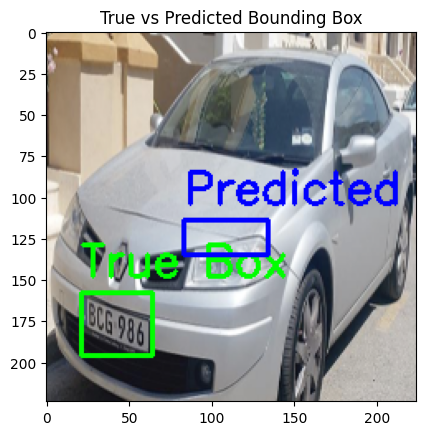

(106, 87, 143, 114)
(107, 86, 141, 111)


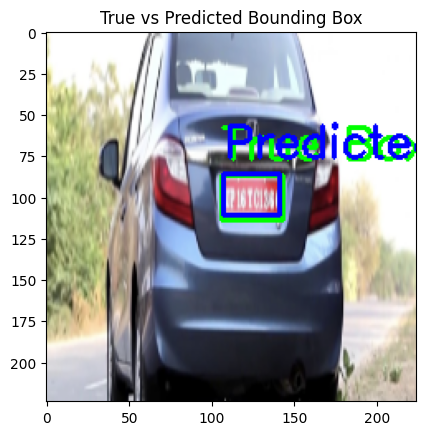

(139, 165, 179, 179)
(135, 163, 177, 179)


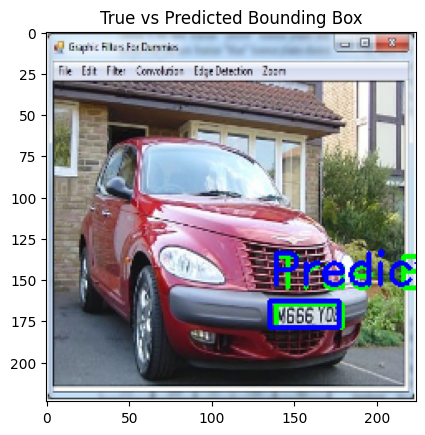

(86, 86, 124, 111)
(37, 44, 65, 69)


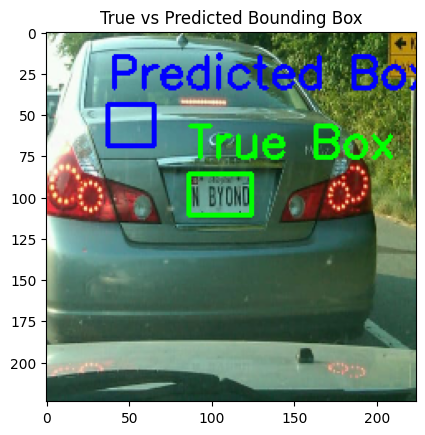

(84, 110, 137, 129)
(85, 114, 141, 135)


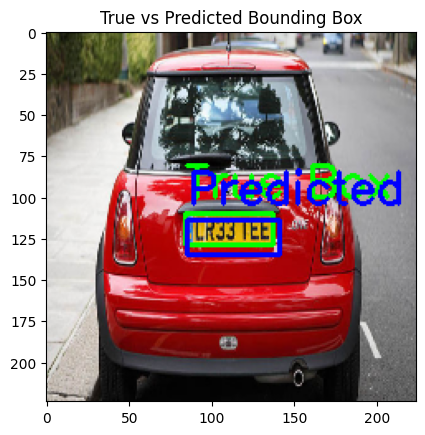

In [43]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Predict bounding boxes on the test set
predictions = model.predict(X_test)

def draw_box(img, box, color, label):
    print(box)
    """
    Draw a bounding box on an image with a label at the top-left corner.
    """
    # Draw the bounding box
    cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)
    # Draw the label
    cv2.putText(img, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Adapt the plotting function to work with non-normalized coordinates
def plot_image_with_bbox(img, box, pred_box):
    # Draw the true and predicted boxes
    #print(pred_box)
    box = box[1]
    pred_box = pred_box[1]
    #print(pred_box)

    draw_box(img, (int(box[0]), int(box[1]), int(box[2]), int(box[3])), (0, 255, 0), "True Box")
    draw_box(img, (int(pred_box[0]), int(pred_box[1]), int(pred_box[2]), int(pred_box[3])), (255, 0, 0), "Predicted Box")

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('True vs Predicted Bounding Box')
    plt.show()

# Plot the bounding boxes on a test image
for i in range(5):  # Just plotting the first 5 images as an example
    plot_image_with_bbox(X_test[i], y_denormalized[i], denormalized_boxes[i])